# Review Sentiment Analysis – Logistic Regression

Exploratory data analysis and baseline modeling for Beyond Flavours reviews.

In [ ]:
from pathlib import Path
from typing import Literal

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

sns.set_theme(context="talk", style="whitegrid")


In [11]:
DATA_PATH = Path("..") / "data" / "raw" / "restaurant_reviews.csv"
df = pd.read_csv(DATA_PATH)
df.head()


,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,7514
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0,2447.0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0,NaN
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0,NaN
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower",5/24/2019 22:11,0,NaN
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers",5/24/2019 21:37,0,NaN


## Clean rating bands and engineer basic text metrics
Convert ratings to numeric, derive the requested sentiment labels, and create
simple text-length descriptors that help explain class separation.

In [12]:
def map_rating_to_label(rating: float) -> Literal["good", "bad"]:

    """Return the coarse sentiment bucket for a numeric rating.


    Ratings of 4.0 and above are marked 'very good', between 3.0 and 4.0 are

    treated as 'bad' (lukewarm), and anything below 3.0 is considered

    'horrible' per the project specification.

    """

    if rating > 3.0:
        return "good"
    return "bad"




df["Rating"] = pd.to_numeric(df["Rating"], errors="coerce")

df["Review"] = df["Review"].fillna("").str.strip()

df = df.dropna(subset=["Rating"])

df = df[df["Review"] != ""].copy()

df["sentiment"] = df["Rating"].apply(map_rating_to_label)

df["review_length"] = df["Review"].str.len()

df["word_count"] = df["Review"].str.split().str.len()

df[["Rating", "sentiment", "review_length", "word_count"]].head()


,Rating,sentiment,review_length,word_count
0,5.0,good,222,41
1,5.0,good,144,27
2,5.0,good,189,31
3,5.0,good,148,28
4,5.0,good,160,27


## Sentiment distribution and length diagnostics
Review how the derived classes balance and whether text length differs by
sentiment bucket

In [13]:
sentiment_counts = (
    df["sentiment"].value_counts().rename_axis("sentiment").to_frame("count")
)
sentiment_counts


,count
sentiment,
good,6315
bad,3639


C:\Users\kavin\AppData\Local\Temp\ipykernel_24276\3378085077.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="sentiment", order=order, ax=axes[0], palette="viridis")


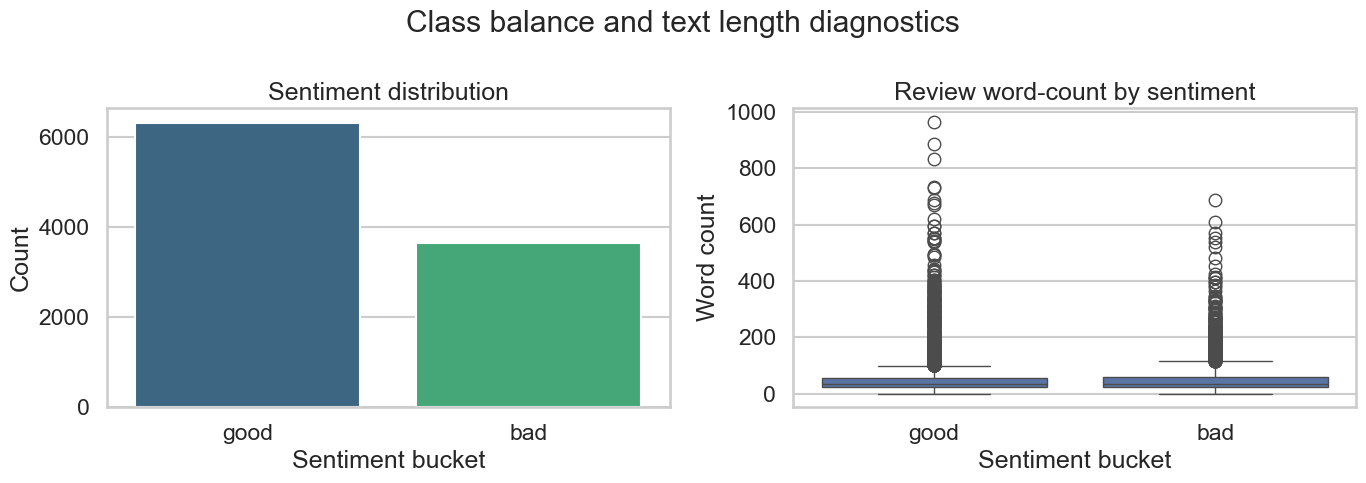

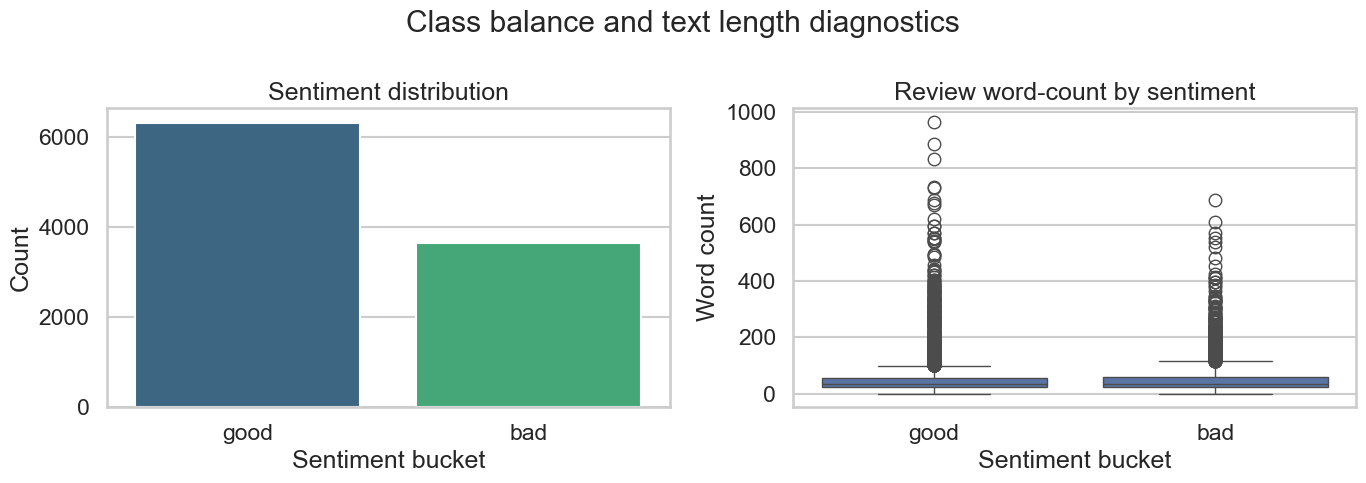

In [19]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
order = ["good", "bad",]
sns.countplot(data=df, x="sentiment", order=order, ax=axes[0], palette="viridis")
axes[0].set_title("Sentiment distribution")
axes[0].set_xlabel("Sentiment bucket")
axes[0].set_ylabel("Count")
sns.boxplot(data=df, x="sentiment", y="word_count", order=order, ax=axes[1])
axes[1].set_title("Review word-count by sentiment")
axes[1].set_xlabel("Sentiment bucket")
axes[1].set_ylabel("Word count")
fig.suptitle("Class balance and text length diagnostics")
fig.tight_layout()
fig


## Logistic regression baseline with TF-IDF features
Train a class-weighted logistic regression model to address the imbalance and
evaluate hold-out performance.

In [15]:
label_counts = df["sentiment"].value_counts()
stratify_labels = df["sentiment"] if label_counts.min() > 1 else None
X_train, X_test, y_train, y_test = train_test_split(
    df["Review"],
    df["sentiment"],
    test_size=0.2,
    random_state=42,
    stratify=stratify_labels,
)

log_reg_pipeline = Pipeline(
    steps=[
        ("tfidf", TfidfVectorizer(ngram_range=(1, 2), min_df=2)),
        ("model", LogisticRegression(max_iter=1000, class_weight="balanced")),
    ]
)
log_reg_pipeline.fit(X_train, y_train)


,steps,"[('tfidf', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [16]:
y_pred = log_reg_pipeline.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=False)
print(report)


              precision    recall  f1-score   support

         bad       0.84      0.89      0.86       728
        good       0.93      0.90      0.92      1263

    accuracy                           0.90      1991
   macro avg       0.89      0.90      0.89      1991
weighted avg       0.90      0.90      0.90      1991



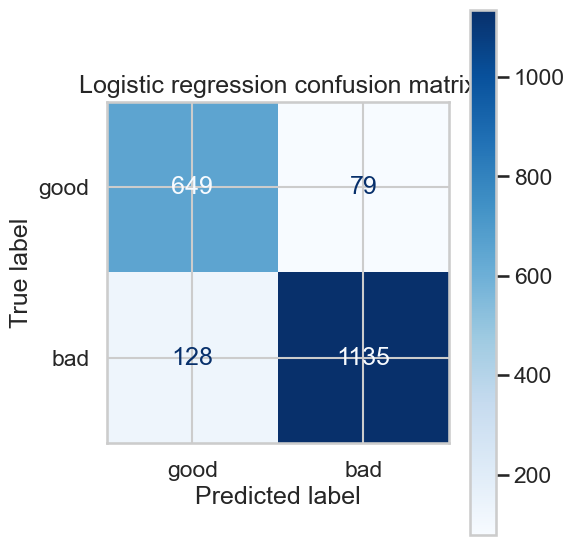

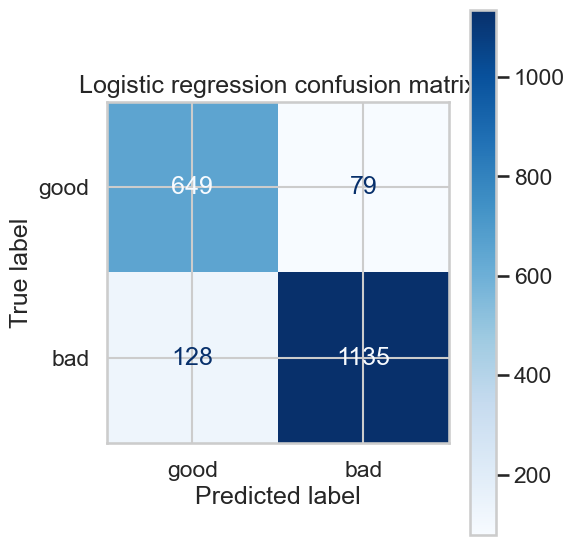

In [18]:
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_estimator(
    log_reg_pipeline,
    X_test,
    y_test,
    display_labels=["good", "bad"],
    cmap="Blues",
    values_format="d",
    ax=ax,
)
ax.set_title("Logistic regression confusion matrix")
fig.tight_layout()
fig
